In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
from loss_2D import generator_loss

1 Physical GPUs, 1 Logical GPUs


In [8]:
# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\test\2_rdriftcorrected.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\test\1_rdriftcorrected.tif'


# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\train\2_rdriftcorrected.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\train\1_rdriftcorrected.tif'

# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine-1frame\low SNR\drift_Average.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine-1frame\low SNR\drift_1frame.tif'

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\FRC-tubulin\frame1.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\FRC-tubulin\frame1.tif'


patch_size = 2048
n_patches = 1
n_channel =  0
add_noise = False

x_test, y_test,_,_ = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold =20 ,ratio=1.0,lp=0.4, augment=False, shuffle=False,
                                   add_noise=add_noise)

(14, 1, 2048, 2048)
14
The training set shape is: (14, 2048, 2048, 1)
The validation set shape is: (0, 2048, 2048, 1)


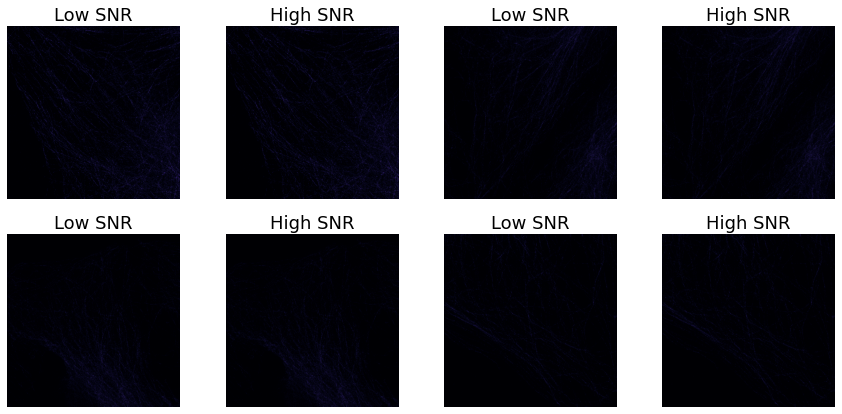

In [4]:
ix = random.sample(range(len(x_test)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [9]:
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\mitochondria\mitochondria_2step_1.h5" 
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\tubulin_2step.h5" 
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\clathrine\clathrine_2step_1.h5" 



filters =[64,128,256]
num_filters = filters[0]
filters_cab=num_filters/8
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction1[i],prediction2[i]= generator(x_test[i:i+1],training=False)
#     prediction2[i] = generator(x_test[i:i+1],training=False)
    prediction1[i] = prediction1[i]/prediction1[i].max()
    prediction2[i] = prediction2[i]/prediction2[i].max()
# prediction1 = prediction1/prediction1.max()
# prediction2= prediction2/prediction2.max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

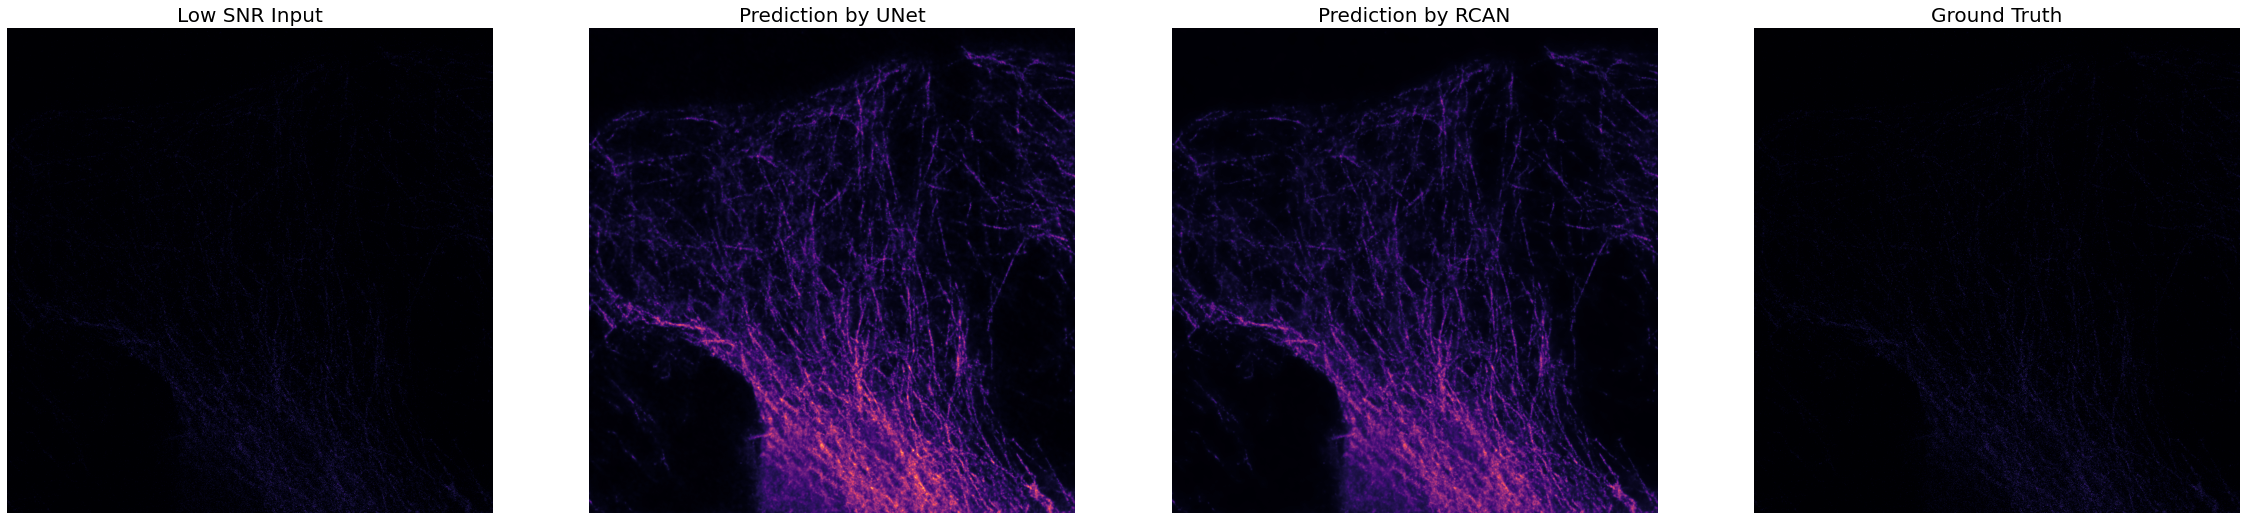

In [10]:
ix = np.random.randint(len(prediction1))
# ix = 0
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 4, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [11]:
save_image_dr = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\FRC-tubulin" 

# pred1_test = np.moveaxis(prediction1,3,1)
# pred2_test = np.moveaxis(prediction2,3,1)
# X_test = np.moveaxis(x_test,3,1)
# Y_test = np.moveaxis(y_test,3,1)


pred1_test = prediction1*(2**16-1)
pred2_test = prediction2*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
pred2_test = pred2_test.astype(np.uint16)

X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

# imwrite(save_image_dr+'/pred1_t2.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/pred_frame1.tif', pred2_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

# imwrite(save_image_dr+'/noisy.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
# imwrite(save_image_dr+'/gt.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

In [ ]:
prediction2 = prediction2**(1.1)
for i in range(len(prediction2)):
    prediction2[i] = prediction2[i]/prediction2[i].max()

In [ ]:
save_parameters_dr = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\tubulin_param.csv"

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((9,len(prediction1)))

imageq_param[0::3,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::3,:] = nmse_psnr_ssim(prediction1,y_test)
imageq_param[2::3,:] = nmse_psnr_ssim(prediction2,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction1', 'prediction2']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:],imageq_param[2,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[3,:],imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[6,:],imageq_param[7,:],imageq_param[8,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")